## Problem 5:  Membrane Equation
\[Implementation\]

Simulate the membrane equation to show how the voltage across the cell membrane will change in response to a step input current, $I(t)$.  Numerically simulate the solution for a duration of least 500 milliseconds with the following parameters:
- Initial condition: $V(0) = V_{rest} = -70 mV$
- Membrane capacitance: $C = 100 pF$
- $ I(t) =
\begin{cases}
100 pA & t \geq 100ms\\
0 pA & t < 100ms
\end{cases}
$
- $G_{Leak} = 5 nS$.

You may find it easiest to run this simulation using the Euler method (see  [Simulating Differential Equations](https://redwood.berkeley.edu/wp-content/uploads/2018/08/diffeq_sim.pdf)), but you are free to use convolution or any other method.

- Try different values of $G_{Leak}$ and $C$ to explore how these parameters affect the rise time and resulting membrane voltage. Plot the results of your simulation and interpret your findings.

- Now examine the effect of adding a single synaptic input that opens a set of sodium channels ($\Delta G_{Na}$).  Sweep $\Delta G_{Na}$ from $0nS$ to $50nS$ and plot the resulting equilibrium membrane potential (by solving for $V$ at $\frac{dV}{dt}=0$) over this range.  
- Now do the same for an inhibitory synaptic input that opens a set of potassium channels by varying $\Delta G_{K}$ over the same range and superimpose on the plot above.
- Finally, in a second plot, show the effect of shunting inhibition by simulating an inhibitory synaptic input that causes chloride channels to open by some amount (say $\Delta G_{Cl} = 10nS$) and now sweep $\Delta G_{Na}$ over the same range as above.  How does this compare to what you would expect from a linear superposition? (plot as a dashed line).  Explain your results. 


# Euler Method Implementation

Implementation of Euler method for the approximation of the output of a 1st order differential equation

Given some differential equation $$y' = f(x)$$
For some step size $h$ and initial value of $x$ at $x_0 = c$,
$$x_{i+1} = x_i + h$$
$$y_{i+1} = y_i + f(x_{i+1})$$

In [98]:
def step(h, x, y, dfdx):
    return dfdx(y, x) + y

def iter_euler_method(h, y_0, dfdx, steps):
    x = 0
    y = y_0
    for _ in range(steps):
        y = step(h, x, y, dfdx)
        x += h
        yield y

# Membrane Equation
Declaring the membrane equation in homogenous form:
$$\frac{dV}{dt} = \frac{I_{in}(t) - (V-V_0)G_{\text{leak}}}{C}$$
- $V$: membrane potential
- $I_{in}(t)$: input current (current flow out of neuron)
- $V_0$: resting potential
- $C$: capacitance of lipid membrane
- $G_{\text{leak}}$: resistance of the lipid membrane

In [99]:
def create_homo_membrane_eqn(i, v_rest, g_leak, c):
    return lambda v, t: (i(t)-(v-v_rest)*g_leak)/c

# Simulations
Now, we begin approximating the membrane equation using Euler's method. We first use the base parameters:
- Initial condition: $V(0) = V_{rest} = -70 mV$
- Membrane capacitance: $C = 100 pF$
- $ I(t) =
\begin{cases}
100 pA & t \geq 100ms\\
0 pA & t < 100ms
\end{cases}
$
- $G_{Leak} = 5 nS$.


In [100]:
import matplotlib.pyplot as plt

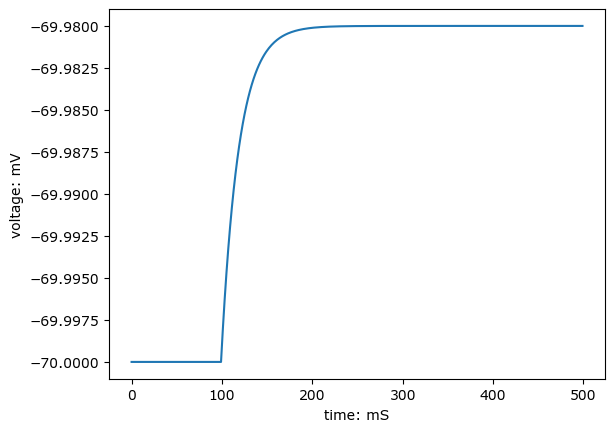

In [101]:
v_rest = -70
g_leak = 0.000005
c = 0.0001

def current(t):
    if t >= 0.1:
        return 0.0000001
    else:
        return 0

v = [v for v in iter_euler_method\
                      (0.001, v_rest, create_homo_membrane_eqn\
                       (current, v_rest, g_leak, c), 500)]

fig, ax = plt.subplots()
ax.set(xlabel='time: mS', ylabel='voltage: mV')
ax.plot(v)

## Varying $G_{Leak}$
Now, we plot graphs of varying $G_{Leak}$, with incrementing steps of $1nS$

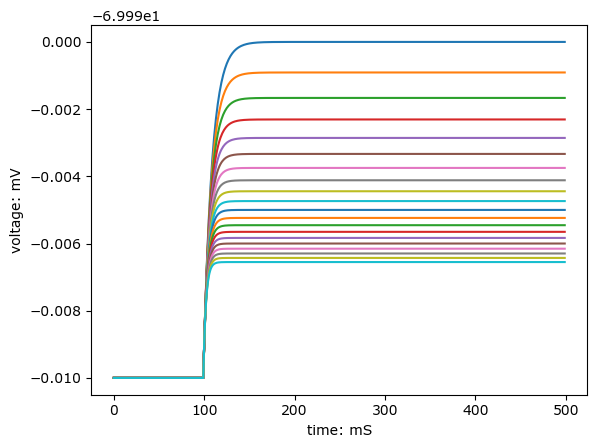

In [102]:
fig, ax = plt.subplots()
ax.set(xlabel='time: mS', ylabel='voltage: mV')
g_step = 0.000001
for i in range(20):
    g = g_leak + i*g_step
    
    v = [v for v in iter_euler_method\
                          (0.001, v_rest, create_homo_membrane_eqn\
                           (current, v_rest, g_leak+g, c), 500)]
    
    ax.plot(v)

### Interpretation
Within the neuron, $G_{\text{Leak}}$ represents the overall conductance of the lipid membrane, or how easy it is for ions to pass through the membrane. By increasing $G_{\text{Leak}}$, we see drop in steady-state voltage after $t = 100ms$, where $I = 100pA$.

Suppose $\frac{dV}{dt} = 0$, then
$$\frac{I_{in}(t) - (V-V_0)G_{\text{leak}}}{C} = 0$$
$$I_{in}(t) = (V-V_0)G_{\text{leak}}$$
$$V = \frac{I_{in}(t)}{G_{\text{leak}}} + V_0$$

Thus, drop in $G_{\text{leak}}$ results in a drop in $V$.

## Varying $C$
Graphs of $C$ with incrementing steps of $50pF$

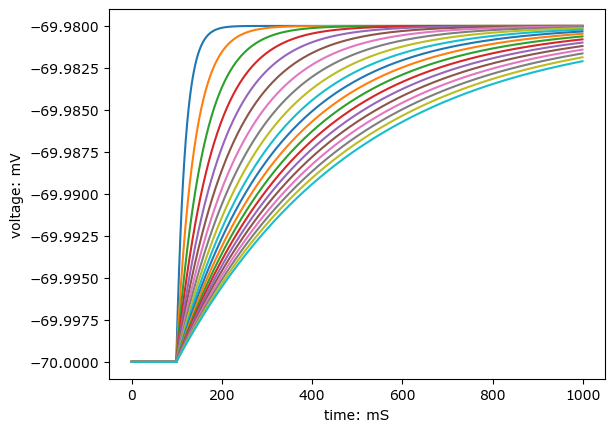

In [103]:
fig, ax = plt.subplots()
ax.set(xlabel='time: mS', ylabel='voltage: mV')
c_step = 0.0001
for i in range(20):
    c_vary = c + i*c_step
    
    v = [v for v in iter_euler_method\
                          (0.001, v_rest, create_homo_membrane_eqn\
                           (current, v_rest, g_leak, c_vary), 1000)]
    ax.plot(v)

### Interpretation
The graph shows that as $C$ increases, we see a decrease in the rate of increase of $V$.

From the membrane equation, we have:
$$\frac{dV}{dt} = \frac{I_{in}(t) - (V-V_0)G_{\text{leak}}}{C}$$
An increase in $C$ will result in a decrease in $\frac{dV}{dt}$ as shown by the graph.

# Membrane Equation with Individual Ionic Conductances
Now, we explore the behavior of modifying the conductances for individual ions across the neuronal membrane. The membrane equation for such a system is:
$$I_{\text{in}}(t) = C\frac{dV}{dt} + G_K(V-V_k) + G_{Na}(V-V_{Na}) + G_{Cl}(V-V_{Cl})$$
- $V$: membrane potential
- $I_{in}(t)$: input current (current flow out of neuron)
- $V_K, V_{Na}, V_{Cl}$: reversal potential for potassum, sodium, and chloride
- $C$: capacitance of lipid membrane
- $G_K, G_{Na}, G_{Cl}$: conductances for potassum, sodium, and chloride

In homogenous form with respect to $V$, we have:
$$\frac{dV}{dt} = \frac{I_{in}(t) - G_K(V-V_K) -G_{Na}(V-V_{Na}) - G_{Cl}(V-V_{Cl})}{C}$$

If $\frac{dV}{dt} = 0$ then
$$V = \frac{I_{\text{in}}(t) + G_kV_k + G_{Na}V_{Na}+G_{Cl}V_{Cl}}{G_K + G_{Na} + G_{Cl}}$$

The ions have the corresponding reversal potentials:
- $V_{Na} = 55mV$
- $V_K = -92mV$
- $V_Cl = -65mV$

In [104]:
def create_homo_membrane_eqn_indiv_ions(i, \
                                        g_k, \
                                        g_na, \
                                        g_cl, \
                                        c, \
                                        v_k = -92, \
                                        v_na = 55, \
                                        v_cl = -65):
    return lambda v, t: (i(t)-g_k(t)*(v-v_k)-g_na(t)*(v-v_na)-g_cl(t)(v-v_cl))/c

def create_membrane_eqn_const_voltage(i, \
                                        g_k, \
                                        g_na, \
                                        g_cl, \
                                        v_k = -92, \
                                        v_na = 55, \
                                        v_cl = -65):
    return lambda t: (i(t)+g_k(t)*v_k +g_na(t)*v_na + g_cl(t)*v_cl)/(g_k(t) + g_na(t) +g_cl(t))

## Varying conductances of ions
Now, we vary the conductance of all the ions and graph the resulting voltage. We use the following values as default:
- $G_K = 2.5nS$
- $G_{Na} = 2.5nS$
- $G_{Cl} = 2.5nS$

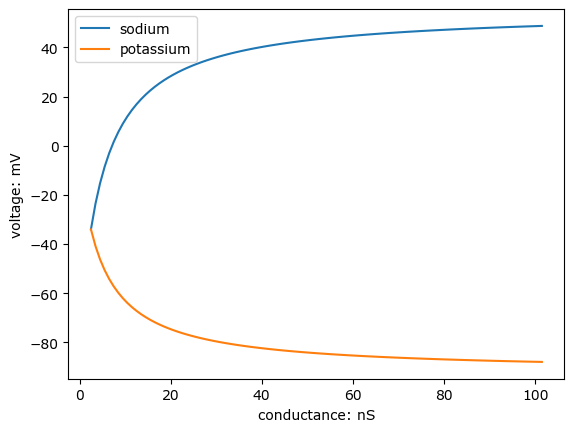

In [105]:
def create_vary_g(g_0, step):
    return lambda t: g_0 + t*step

step = 0.000001
default_g = 0.0000025

vary_na = create_membrane_eqn_const_voltage(lambda _: 0, \
                                           lambda _: default_g, \
                                           create_vary_g(default_g, step), \
                                           lambda _: default_g)
vary_k = create_membrane_eqn_const_voltage(lambda _: 0, \
                                           create_vary_g(default_g, step), \
                                           lambda _: default_g, \
                                           lambda _: default_g)

n = 100
v_na = [vary_na(x) for x in range(n)]
g = [default_g*10**6 + x*step*10**6 for x in range(n)]
v_k = [vary_k(x) for x in range(n)]

fig, ax = plt.subplots()

ax.plot(g, v_na, label="sodium")
ax.plot(g, v_k, label="potassium")
ax.set(xlabel='conductance: nS', ylabel='voltage: mV')
ax.legend(loc="upper left")

## Interpretation
As the conductances of individual ion channels increase, the voltage approaches the reversal potential of the respective ions.

## Varying $G_{Cl}$ conductance with respect to $G_{Na}$

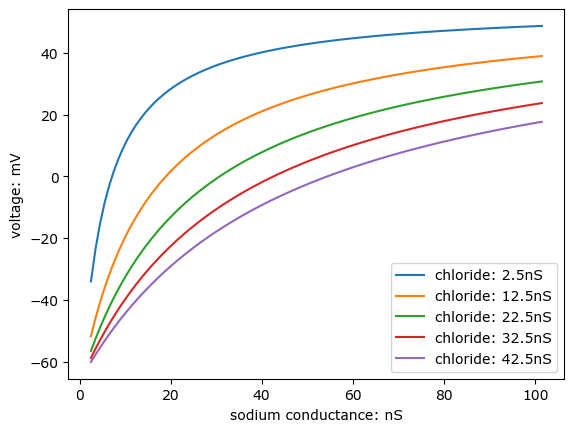

In [106]:
cl_1 = create_membrane_eqn_const_voltage(lambda _: 0, \
                                           lambda _: default_g, \
                                           create_vary_g(default_g, step), \
                                           lambda _: default_g)
fig, ax = plt.subplots()
ax.set(xlabel='sodium conductance: nS', ylabel='voltage: mV')
for i in range(5):
    g_cl = default_g + i*step*10
    cl_eq = create_membrane_eqn_const_voltage(lambda _: 0, \
                                           lambda _: default_g, \
                                           create_vary_g(default_g, step), \
                                           lambda _: g_cl)
    
    ax.plot(g, [cl_eq(x) for x in range(n)], label="chloride: " + str(round(g_cl*10**6, 3)) + "nS")
ax.legend(loc="lower right")

## Interpretation
An increase in permeability to $Cl^-$ ions in the lipid membrane reduces the voltage change caused by increases in permeability to other ions. This is expected since the reversal potential of $Cl^-$ is $-65mV$ which is around the resting potential of neurons. Hence, increases in conductance to $Cl^-$ will dampen voltage fluctuations from the resting potential, as demonstrated in the graph.